<a href="https://colab.research.google.com/github/arfafax/StyleGAN2_experiments/blob/master/GPU_Barycentric_Cross_Network_Interpolation_with_different_layer_interpolation_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Barycentric Cross-Network Interpolation with different layer interpolation rates

### Credits
Thanks to [@shawwn](https://twitter.com/theshawwn) for helping me optimize the cross-network interpolation code.

The code for generating the triangle visualization is from [Brandon Mechtley](https://github.com/bmechtley/barycentric).

### Shameless Plug
If you enjoyed this and want to see more projects like it in the future, consider supporting me on Ko-fi or Patreon.

-arfa


<div>
<a href="https://www.twitter.com/arfafax">
<img src="https://thisfursonadoesnotexist.com/arfa_sig.png" width="350"/>
</a>
</div>
<div>
<a href="https://ko-fi.com/arfafax">
<img src="https://cdn.ko-fi.com/cdn/kofi3.png?v=2" width="220"/>
</a>
<a href="https://www.patreon.com/arfafax">
<img src="https://c5.patreon.com/external/logo/become_a_patron_button.png" width="235"/>
</a>
</div>


Select the models to interpolate between. They have all been transfer learned from the same source (ThisFursonaDoesNotExist).


In [3]:
import gdown
network_a_name = "furry"
network_b_name = "pony"
network_c_name = "anime"
# Furry
gdown.download('https://drive.google.com/uc?id=1t7E8NEqK_gVJwxrWEihR1IcPfekaBc1d', 'network-{}.pkl'.format(network_a_name), quiet=False)
# Pony
gdown.download('https://drive.google.com/uc?id=1HmDTPoUlhVcUQ6-D0gkGMiBQZ3nNUBg9', 'network-{}.pkl'.format(network_b_name), quiet=False)
# Anime
gdown.download('https://drive.google.com/uc?id=1rfO_Iyg7cfjrs2fUsjjAsGb2_wDLdUYC', 'network-{}.pkl'.format(network_c_name), quiet=False)
# FFHQ
#gdown.download('https://drive.google.com/uc?id=1XeY94kGlULuxoHUSHIDWH8BQ4_L1UBKJ', 'network-{}.pkl'.format(network_b_name), quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1t7E8NEqK_gVJwxrWEihR1IcPfekaBc1d
To: /content/network-furry.pkl
364MB [00:02, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HmDTPoUlhVcUQ6-D0gkGMiBQZ3nNUBg9
To: /content/network-pony.pkl
364MB [00:02, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rfO_Iyg7cfjrs2fUsjjAsGb2_wDLdUYC
To: /content/network-anime.pkl
364MB [00:03, 102MB/s] 


'network-anime.pkl'

## Boring tensorflow stuff

In [1]:
!nvidia-smi

Tue Aug 25 21:18:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/shawwn/stylegan2 -b estimator /content/stylegan2

Cloning into '/content/stylegan2'...
remote: Enumerating objects: 1463, done.
remote: Total 1463 (delta 0), reused 0 (delta 0), pack-reused 1463
Receiving objects: 100% (1463/1463), 933.62 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (1044/1044), done.


In [4]:
%tensorflow_version 1.x
%cd /content/stylegan2

TensorFlow 1.x selected.
/content/stylegan2


In [5]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import scipy
import tensorflow as tf
import re



attach_debugger <function attach_debugger at 0x7f42ffcf47b8>
print_status <function print_status at 0x7f42ffcf4ae8>
freeze_forever <function freeze_forever at 0x7f42ffcf4ea0>
quit <function quit at 0x7f42ffcf71e0>
save_and_quit <function save_and_quit at 0x7f42ffcf7510>
throw_exception <function throw_exception at 0x7f42ffcf77b8>


In [6]:
tflib.init_tf()
_G1, _D1, Gs1 = pickle.load(open("/content/network-{}.pkl".format(network_a_name), "rb"))
_G2, _D2, Gs2 = pickle.load(open("/content/network-{}.pkl".format(network_b_name), "rb"))
_G3, _D3, Gs3 = pickle.load(open("/content/network-{}.pkl".format(network_c_name), "rb"))
_G, _D, Gs = pickle.load(open("/content/network-{}.pkl".format(network_a_name), "rb"))


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [17]:
from dnnlib.tflib import tfutil
import tflex
names = []

for name in Gs1.trainables.keys():
    if name not in Gs1.trainables:
        print("Not restoring (not present):     {}".format(name))
    elif Gs2.trainables[name].shape != Gs1.trainables[name].shape:
        print("Not restoring (different shape): {}".format(name))

    if name in Gs1.trainables and Gs2.trainables[name].shape == Gs1.trainables[name].shape:
        names.append(name)


In [18]:
print(names)

['G_synthesis/4x4/Const/const', 'G_synthesis/4x4/Conv/weight', 'G_synthesis/4x4/Conv/mod_weight', 'G_synthesis/4x4/Conv/mod_bias', 'G_synthesis/4x4/Conv/noise_strength', 'G_synthesis/4x4/Conv/bias', 'G_synthesis/4x4/ToRGB/weight', 'G_synthesis/4x4/ToRGB/mod_weight', 'G_synthesis/4x4/ToRGB/mod_bias', 'G_synthesis/4x4/ToRGB/bias', 'G_synthesis/8x8/Conv0_up/weight', 'G_synthesis/8x8/Conv0_up/mod_weight', 'G_synthesis/8x8/Conv0_up/mod_bias', 'G_synthesis/8x8/Conv0_up/noise_strength', 'G_synthesis/8x8/Conv0_up/bias', 'G_synthesis/8x8/Conv1/weight', 'G_synthesis/8x8/Conv1/mod_weight', 'G_synthesis/8x8/Conv1/mod_bias', 'G_synthesis/8x8/Conv1/noise_strength', 'G_synthesis/8x8/Conv1/bias', 'G_synthesis/8x8/ToRGB/weight', 'G_synthesis/8x8/ToRGB/mod_weight', 'G_synthesis/8x8/ToRGB/mod_bias', 'G_synthesis/8x8/ToRGB/bias', 'G_synthesis/16x16/Conv0_up/weight', 'G_synthesis/16x16/Conv0_up/mod_weight', 'G_synthesis/16x16/Conv0_up/mod_bias', 'G_synthesis/16x16/Conv0_up/noise_strength', 'G_synthesis/16x

In [43]:
# Select the variables to interpolate for each point
matches = [
           '.*(4x4|8x8|16x16)',         #p0
           '.*(32x32|64x64|128x128)',   #p1
           '.*(256x256|512x512)'        #p2
           ]
# matches = ['.*(4x4|8x8|16x16|32x32|64x64)',
#            '.*(128x128|256x256|512x512)',
#            '.*Dense'
#]

filtered_names = []
bs = []
ops = []
for match in matches:
    match_names = [n for n in names if re.match(match, n)]
    filtered_names.append(match_names)
    b_cur = [tf.Variable(0.0), tf.Variable(0.5), tf.Variable(0.5)]
    ops_cur = []
    for name in match_names:
        ops_cur.append(tf.assign(Gs.vars[name], b_cur[0]*Gs1.vars[name] + b_cur[1]*Gs2.vars[name] + b_cur[2]*Gs3.vars[name]))
    bs.append(b_cur)
    ops.append(ops_cur)

print(filtered_names)

[['G_synthesis/4x4/Const/const', 'G_synthesis/4x4/Conv/weight', 'G_synthesis/4x4/Conv/mod_weight', 'G_synthesis/4x4/Conv/mod_bias', 'G_synthesis/4x4/Conv/noise_strength', 'G_synthesis/4x4/Conv/bias', 'G_synthesis/4x4/ToRGB/weight', 'G_synthesis/4x4/ToRGB/mod_weight', 'G_synthesis/4x4/ToRGB/mod_bias', 'G_synthesis/4x4/ToRGB/bias', 'G_synthesis/8x8/Conv0_up/weight', 'G_synthesis/8x8/Conv0_up/mod_weight', 'G_synthesis/8x8/Conv0_up/mod_bias', 'G_synthesis/8x8/Conv0_up/noise_strength', 'G_synthesis/8x8/Conv0_up/bias', 'G_synthesis/8x8/Conv1/weight', 'G_synthesis/8x8/Conv1/mod_weight', 'G_synthesis/8x8/Conv1/mod_bias', 'G_synthesis/8x8/Conv1/noise_strength', 'G_synthesis/8x8/Conv1/bias', 'G_synthesis/8x8/ToRGB/weight', 'G_synthesis/8x8/ToRGB/mod_weight', 'G_synthesis/8x8/ToRGB/mod_bias', 'G_synthesis/8x8/ToRGB/bias', 'G_synthesis/16x16/Conv0_up/weight', 'G_synthesis/16x16/Conv0_up/mod_weight', 'G_synthesis/16x16/Conv0_up/mod_bias', 'G_synthesis/16x16/Conv0_up/noise_strength', 'G_synthesis/16

In [44]:
sess = tf.get_default_session()

In [45]:
def barycentric_interp(b_v_low, b_v_med, b_v_high):
    global bs
    global ops

    for i in range(len(b_v_low)):
        bs[0][i].load(b_v_low[i])
        bs[1][i].load(b_v_med[i])
        bs[2][i].load(b_v_high[i])

    for j in range(len(ops)):
        sess.run(ops[j])


This is the path each point takes throughout the video. In this case, it's just permutations of the three corner coordinates, but any list of barycentric coordinates should work.

In [23]:
# This is the path each point takes throughout the video
A = [0,0,1]
B = [0,1,0]
C = [1,0,0]
points_p0 = [A, A, A, A, A, A, A, A, A, B, B, B, B, B, B, B, B, B, C, C, C, C, C, C, C, C, C]
points_p1 = [A, A, A, B, B, B, C, C, C, A, A, A, B, B, B, C, C, C, A, A, A, B, B, B, C, C, C]
points_p2 = [A, B, C, A, B, C, A, B, C, A, B, C, A, B, C, A, B, C, A, B, C, A, B, C, A, B, C]

# This function interpolates smoothly between the points in a given list, where t is some value that goes from 0 to 1 throughout the video
def get_point(t, p_list, duration_sec = 60.0, mp4_fps = 20):
    total_frames = duration_sec * mp4_fps #1200
    frames_per_step = total_frames/(len(p_list)) #200
    current_frame = int(t * total_frames)
    
    p1 = int(current_frame // frames_per_step) % len(p_list)
    p2 = (p1 + 1)%len(p_list)
    lam = (current_frame % frames_per_step) / frames_per_step
    #print(t, total_frames, frames_per_step, current_frame, p1, p2, lam)
    point1 = np.array(p_list[p1])
    point2 = np.array(p_list[p2])
    return (1-lam)*point1 + (lam)*point2 

In [26]:
cur_frame = 0
def make_video(grid_size = [4, 4], duration_sec = 60.0, mp4_fps = 20, random_seed=397):
    global cur_frame
    cur_frame = 0

    image_shrink = 1
    image_zoom = 1
    smoothing_sec = 1.0
    mp4_codec = 'libx264'
    mp4_bitrate = '5M'
    mp4_file = 'random_grid_%s.mp4' % random_seed
    minibatch_size = 8

    num_frames = int(np.rint(duration_sec * mp4_fps))
    random_state = np.random.RandomState(random_seed)

    # Generate latent vectors
    shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
    all_latents = random_state.randn(*shape).astype(np.float32)
    import scipy
    all_latents = scipy.ndimage.gaussian_filter(all_latents,
                   [smoothing_sec * mp4_fps] + [0] * len(Gs.input_shape), mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))


    def create_image_grid(images, grid_size=None):
        assert images.ndim == 3 or images.ndim == 4
        num, img_h, img_w, channels = images.shape

        if grid_size is not None:
            grid_w, grid_h = tuple(grid_size)
        else:
            grid_w = max(int(np.ceil(np.sqrt(num))), 1)
            grid_h = max((num - 1) // grid_w + 1, 1)

        grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
        for idx in range(num):
            x = (idx % grid_w) * img_w
            y = (idx // grid_w) * img_h
            grid[y : y + img_h, x : x + img_w] = images[idx]
        return grid

    # Frame generation func for moviepy.
    def make_frame(t):
        global cur_frame
        frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))

        t1 = cur_frame / (num_frames - 1)
        b1 = get_point(t1, points_p0, duration_sec=duration_sec, mp4_fps=mp4_fps)
        b2 = get_point(t1, points_p1, duration_sec=duration_sec, mp4_fps=mp4_fps)
        b3 = get_point(t1, points_p2, duration_sec=duration_sec, mp4_fps=mp4_fps)
        barycentric_interp(b1, b2, b3)
        latents = all_latents[frame_idx]
        #latents = all_latents[0]
        cur_frame += 1
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=0.45, randomize_noise=False, output_transform=fmt)# **synthesis_kwargs

        grid = create_image_grid(images, grid_size)
        if image_zoom > 1:
            grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
        if grid.shape[2] == 1:
            grid = grid.repeat(3, 2) # grayscale => RGB
        return grid

    # Generate video.
    import moviepy.editor
    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

    return mp4_file


# Generate a grid of cross-network interpolations

In [27]:
#@title Generate an interpolation video { run: "auto", form-width: "30%" }
random_seed = 1234 #@param {type:"integer"}
duration_sec = 60.0 #@param {type:"number"}
mp4_fps = 20 #@param {type:"integer"}
grid_width =  3 #@param {type:"integer"}
grid_height = 3 #@param {type:"integer"}
output_filename = make_video(grid_size=[grid_width,grid_height], duration_sec=duration_sec, mp4_fps=mp4_fps, random_seed=random_seed)

1200
[MoviePy] >>>> Building video random_grid_1237.mp4
[MoviePy] Writing video random_grid_1237.mp4


100%|█████████▉| 1200/1201 [12:10<00:00,  1.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: random_grid_1237.mp4 



In [28]:
# You may need to run this cell twice to get the video to download
from google.colab import files
files.download(output_filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate the triangle visualization

In [29]:
%cd /content
!git clone https://github.com/bmechtley/barycentric.git

/content
Cloning into 'barycentric'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.


In [30]:
%cd barycentric

/content/barycentric


In [31]:
!cp barycentric/coordinates.py .

In [32]:
%load_ext sympyprinting

import itertools as it

from pylab import *

import coordinates
#reload(coordinates)
from coordinates import *

import notebookutils
#reload(notebookutils)
from notebookutils import *

set_printoptions(precision=3)

In [33]:
def polyshow2(
    coords, 
    color=None, 
    label=None, 
    labelvertices=False, 
    polycolor=None, 
    lines=[]
):
    '''
    Plot a regular convex polygon surrounding one or more barycentric 
    coordinates within the it. Vertices and corners will be labeled
    sequentially starting at 0.

    Args:
        coords (np.ndarray or list): one or more barycentric coordinates of 
            equal arbitrary dimension. The dimensionality of the coordinates 
            will correspond to the number of vertices of the polygon that is
            drawn.
        color (str or list, optional): color in which to draw the coords. If
            color is a list of the same length as coords, each entry will 
            correspond to the respective coordinates.
    '''


    # Defaults.
    coords = np.array(coords)
    if len(coords.shape) < 2: coords = [coords]
    for coord in coords:
        if np.sum(coord) > 0:
            coord /= np.sum(coord)

    if color == None: color = 'blue'
    if type(color) == str: color = [color] * len(coords)

    if label == None: label = ''
    if type(label) == str: label = [label] * len(coords)

    # Number of sides.
    d = len(coords[0])

    # Cartesian coordinates of the vertices of the polygon and each point.
    corners = polycorners(d)
    cart = np.array([
        np.sum([
            c * cnr 
            for c, cnr in zip(coord, corners)
        ], axis=0) 
        for coord in coords
    ])

    # Figure/axes setup.
    f = pp.figure(frameon=False)
    ax = pp.axes(frameon=False)
    ax.axis('equal')
    pp.xticks([])
    pp.yticks([])

    # Add the polygon and its vertices to the figure.
    ax.add_patch(pp.Polygon(corners, closed=True, fill=False, alpha=0.5))
    #ax.scatter(corners[:,0], corners[:,1], color='red', s=50)
    if labelvertices:
        map(lambda i: verttext(corners[i], '$v_{%d}$' % i), range(len(corners)))
    verttext(corners[0], network_a_name, color='black')
    verttext(corners[1], "{}     ".format(network_b_name), color="black")
    verttext(corners[2], "     {}".format(network_c_name), color="black")

    # Add any extra lines to the figure.
    map(ax.add_line, lines)

    # Add the interior points and their labels.
    ax.scatter(cart[:,0], cart[:,1], color=color, s=100)

    for c, txt, clr in zip(cart, label, color):
        verttext(c, txt, color=clr)

    return f

In [34]:
def testpoly(p, i, sides=False):
    if type(p) == ndarray and len(p.shape) < 2: p = [p]
    elif type(p) == ndarray and len(p.shape) > 1:    
        p = list(array(r) for r in p)
    
    n = len(p)    # number of points
    d = len(p[0]) # number of sides
    
    # q-points are bary. coords for the projection of points in p along each edge.
    q = concatenate([baryedges(pi) for pi in p]) if sides else np.array([])
    
    # Which point each projected point references.
    qindices = (arange(n) * ones((d, n), dtype=int)).T.flatten() if sides else np.array([])
    
    # Labels for every point.
    plabels = ['$p_{%d}$' % i for i in range(n)]
    qlabels = [
        '$q_{%d,%d%d}$' % (a, b, c) 
        for (a, (b, c)) in list(it.product(
            range(n), 
            zip(
                range(d), 
                [i % d for i in range(1, d + 1)]
            )
        ))
    ] if sides else []
    
    # Colors for every point.
    cm = get_cmap("hsv")
    pcolors = [cm(float(i) / n)[0:3] + (.9,) for i in range(n)]
    qcolors = [pcolors[i][0:3] + (.5,) for i in qindices] if sides else []
    
    # Cartesian coordinates for points and closest points along the sides.
    pcart = [bary2cart(pi) for pi in p]
    qcart = bary2cart(q) if sides else np.array([])
    
    # Lines that connect each q-point to its reference point.
    lines = [
        Line2D(
            (pcart[i / len(p[0])][0], qcart[i, 0] + .00001),
            (pcart[i / len(p[0])][1], qcart[i, 1]),
            color = qcolors[i]
        ) for i in range(len(qcart))
    ] if sides else []
    
    # Create the view.
    f = polyshow2(
        p + list(q),
        color=pcolors + qcolors,
        label=plabels + qlabels,
        labelvertices=True,
        lines=lines
    )
    plt.savefig('frames/{:04d}.png'.format(i), dpi=200)
    # Show it.
    #svgfig(f)

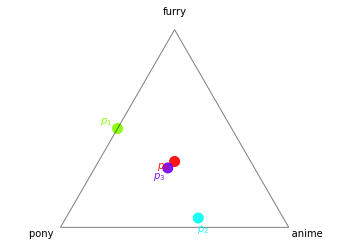

In [46]:
testpoly([np.array([1/3,1/3,1/3]),np.array([1/2,1/2,0]), rand(3), rand(3)], 0, sides=False)

In [36]:
def cart2bary(x, y):
    corners = polycorners(3)
    x1, y1 = corners[0]
    x2, y2 = corners[1]
    x3, y3 = corners[2]
    l1 = ((y2-y3)*(x-x3)+(x3-x2)*(y-y3))/((y2-y3)*(x1-x3)+(x3-x2)*(y1-y3))
    l2 = ((y3-y1)*(x-x3)+(x1-x3)*(y-y3))/((y2-y3)*(x1-x3)+(x3-x2)*(y1-y3))
    l3 = 1-l1-l2
    return [l1,l2,l3]

In [37]:
circumcircle(bary2cart(np.array([0,0,1/2])), bary2cart(np.array([0,1/2,0])), bary2cart(np.array([1/2,0,0])))

(0.5, 0.5)

In [38]:
#!rm frames/*.png
!mkdir frames

In [ ]:
frames = duration_sec * mp4_fps
for i in range(int(frames)):
    t = i / frames
    b1 = get_point(t, points_p0, duration_sec=frames/mp4_fps, mp4_fps=mp4_fps)
    b2 = get_point(t, points_p1, duration_sec=frames/mp4_fps, mp4_fps=mp4_fps)
    b3 = get_point(t, points_p2, duration_sec=frames/mp4_fps, mp4_fps=mp4_fps)
    #testpoly(b2, i, sides=False)
    testpoly([b1, b2, b3], i, sides=False)

# Put the two videos together side-by-side

In [ ]:
!ffmpeg -r 20 -i frames/%04d.png -c:v libx264 -vf fps=20 -vf scale=1536:1200 -pix_fmt yuv420p /content/triangle.mp4

In [ ]:
!ffmpeg -i $(find /content/stylegan2 -name "*.mp4") -i /content/triangle.mp4 -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' -map [vid] -c:v libx264 -crf 29 /content/output.mp4

In [42]:
# You may need to run this cell twice to get the video to download
from google.colab import files
files.download("/content/output.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>